# Cross resonance analysis
In this notebook we call various method of CRModel() to create a coupled-qubit system and extract the hamiltonian components (ZX, ZZ, etc...)

We also simulate the time evolution of the conditional term to have a rough estimation of the gate time.

Useful references:

https://journals.aps.org/pra/pdf/10.1103/PhysRevA.101.052308 

https://github.com/zhanggy2004/QuTiPNotebooks/blob/master/CRGate/CrossResonanceGate.ipynb

In [1]:
from modeling.gates.cross_resonance import CRModel
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

### Preliminary call
We find the exchange rate J, anharmonicities through numerical diagonalization with a preliminary call.

In [3]:
system_parameters = {
    "w1" : 4.5,
    "w2": 4.4,
    "wc": 7,
    "a1": -0.3, # This is arbitrary and is ignored when mode_a is not "input"
    "a2": -0.31, # This is arbitrary and is ignored when mode_a is not "input"
    "g1": 0.09,
    "g2": 0.09,
    "C1": 90e-15,
    "C2": 90e-15,
    "use_dressed_freq": True,
    "mode_a": "numeric_dressed",
    "truncated_dim": 11
}
crmodel = CRModel(**system_parameters)
crmodel.create_report()

Frequencies:  4.496432007269544 4.3962781671461 [GHz / 2pi]
Anharmonicities:  -0.2434907356448548 -0.24430447405557665 [GHz / 2pi]
Exchange rate J:  -0.0031731569344874136 [GHz / 2pi]


### Analytical sweep
We use the correct anharmonicity value and define $\omega_2$ as a list, then we compute the perturbative hamiltonian strengths.

In [4]:
delta = np.linspace(-0.7,0.7, 1000)
system_parameters = {
    "w1" : 4.5,
    "w2": 4.5- delta,
    "wc": 7,
    "a1": -0.243,
    "a2": -0.243,
    "g1": 0.09,
    "g2": 0.09,
    "C1": 90e-15,
    "C2": 90e-15,
    "use_dressed_freq": False,
    "mode_a": "input",
    "truncated_dim": 11
}
crmodel = CRModel(**system_parameters)

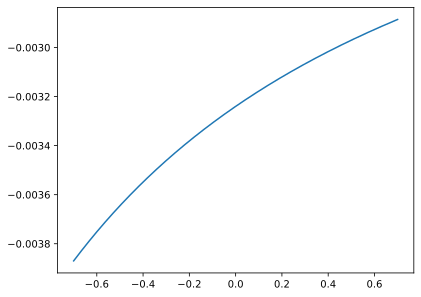

In [5]:
plt.plot(delta, crmodel.J)

(-0.001, 0.001)

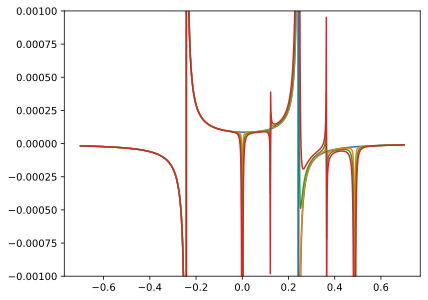

In [6]:
_, _, zz_0 = crmodel.zz_strength(0)
_, _, zz_1 = crmodel.zz_strength(0.01)
_, _, zz_2 = crmodel.zz_strength(0.02)
_, _, zz_3 = crmodel.zz_strength(0.03)
ylims = [-1e-3, 1e-3]
plt.plot(delta, zz_0)
plt.plot(delta, zz_1)
plt.plot(delta, zz_2)
plt.plot(delta, zz_3)
plt.vlines(-system_parameters['a1'], ylims[0], ylims[1])
plt.ylim(ylims)

(-0.01, 0.01)

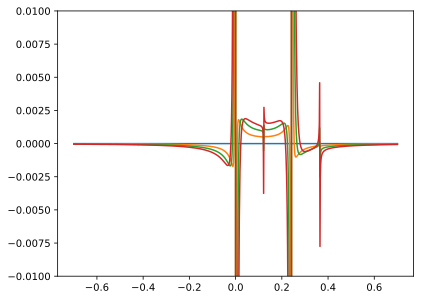

In [7]:
zx_0 = crmodel.zx_strength(0)
zx_1 = crmodel.zx_strength(0.01)
zx_2 = crmodel.zx_strength(0.02)
zx_3 = crmodel.zx_strength(0.03)
ylims = [-1e-2, 1e-2]
plt.plot(delta, zx_0)
plt.plot(delta, zx_1)
plt.plot(delta, zx_2)
plt.plot(delta, zx_3)
plt.ylim(ylims)

(-1.0, 1.0)

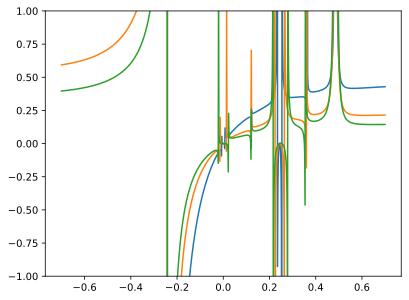

In [13]:
plt.plot(delta, zz_1 / zx_1)
plt.plot(delta, zz_2 / zx_2)
plt.plot(delta, zz_3 / zx_3)
plt.ylim([-1, 1])

### CR gate evolution
We optimize $\omega_2$, $g_1$ and $g_2$ to achieve reasonable CR gate parameters. We can also Echo away some spurious components.

(-1.0, 1.0)

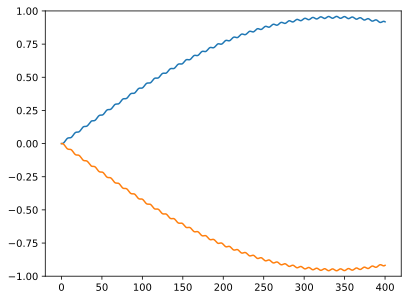

In [32]:
system_parameters = {
    "w1" : 4.5,
    "w2": 4.402456766841759,
    "wc": 7.0001590796504,
    "a1": -0.243,
    "a2": -0.243,
    "g1": 0.08, # 0.08773759814242038, with drive 0.0102100358062578057
    "g2": 0.08, #0.08773759814242038, with drive 0.0102100358062578057
    "C1": 90e-15,
    "C2": 90e-15,
    "use_dressed_freq": True,
    "mode_a": "numeric_dressed",
    "truncated_dim": 11
}

crmodel = CRModel(**system_parameters)
drive_strength = 0.015
# Initial states
# |00>
psidown = qt.tensor(qt.basis(2, 1), qt.basis(2, 1))
# |10>
psiup = qt.tensor(qt.basis(2, 0), qt.basis(2, 1))
# |+0>
psiplus = qt.tensor((qt.basis(2, 1) + qt.basis(2, 0))/np.sqrt(2),
                    qt.basis(2, 1))

tlist = np.linspace(0, 400, 501)
evolution_00 = crmodel.time_evolution(init_state=psidown, drive_strength=drive_strength, tlist=tlist, m2=0., echo=False)
evolution_10 = crmodel.time_evolution(init_state=psiup, drive_strength=drive_strength, tlist=tlist, m2=0., echo=False)

plt.plot(tlist, evolution_00[4])
plt.plot(tlist, evolution_10[4])
plt.ylim([-1, 1])

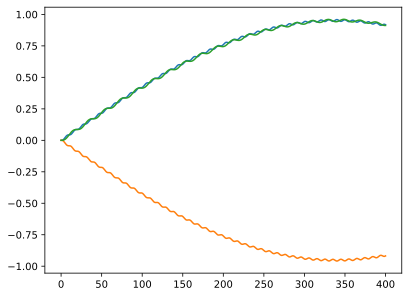

In [18]:
# Here we check that the echo mode is insensitive to the "m2" parameter
evolution_00_echo = crmodel.time_evolution(init_state=psidown, drive_strength=drive_strength, tlist=tlist, m2=0.1, echo=True, tsteps=601)
plt.plot(tlist, evolution_00[4])
plt.plot(tlist, evolution_10[4])
plt.plot(tlist, evolution_00_echo[4])

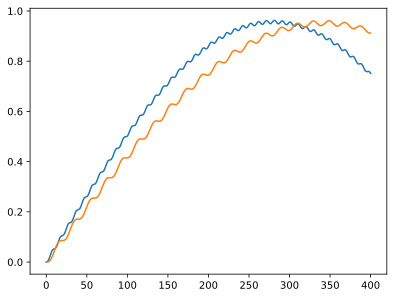

In [21]:
# Indeed, the non-echo mode picks up the spurius oscillation.
evolution_00_spurious = crmodel.time_evolution(init_state=psidown, drive_strength=drive_strength, tlist=tlist, m2=0.005, echo=False)
plt.plot(tlist, evolution_00_spurious[4])
plt.plot(tlist, evolution_00_echo[4])

In [25]:
# We can estimate the T1 Purcell of the individual qubits through the coupling cavity.
delta = 2.5*1e9
kappa_target = 1*1e6
k_purcell = kappa_target* (80*1e6/delta)**2
T1_purcell = 1/(2*np.pi*k_purcell)
print(T1_purcell * 1e6, "us")

155.42474911317905 us


### Static ZZ landscape

In [26]:
delta = np.linspace(-0.7,0.7, 101)
resonator_freq = np.linspace(6, 9, 101)
zz_numeric = np.zeros((delta.shape[0], resonator_freq.shape[0]))
for i, d in enumerate(delta):
    for j, wc in enumerate(resonator_freq):
        system_parameters = {
            "w1" : 4.5,
            "w2": 4.5 + d,
            "wc": wc,
            "a1": -0.243,
            "a2": -0.243,
            "g1": 0.09,
            "g2": 0.09,
            "C1": 90e-15,
            "C2": 90e-15,
            "use_dressed_freq": False,
            "mode_a": "input",
            "truncated_dim": 5
        }
        crmodel = CRModel(**system_parameters)
        zz_numeric[i, j] = crmodel.zz_strength(0)[0]

 C:\Users\pc\Desktop\work\QDAST\src\modeling\gates\cross_resonance.py: 64RuntimeWarning: divide by zero encountered in scalar divide
 C:\Users\pc\Desktop\work\QDAST\src\modeling\gates\cross_resonance.py: 66RuntimeWarning: divide by zero encountered in scalar divide
 C:\Users\pc\Desktop\work\QDAST\src\modeling\gates\cross_resonance.py: 69RuntimeWarning: invalid value encountered in scalar add
 C:\Users\pc\Desktop\work\QDAST\src\modeling\gates\cross_resonance.py: 64

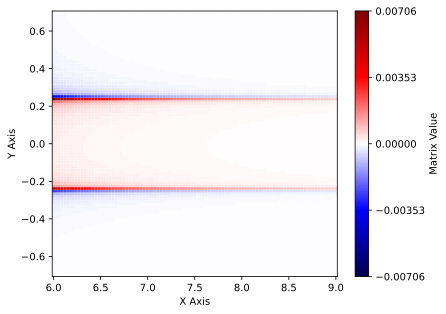

In [30]:
zz_str_masked = np.ma.masked_invalid(zz_numeric)
plt.pcolor(resonator_freq, delta, zz_str_masked, cmap='seismic', vmin=-np.abs(zz_str_masked).max(), vmax=np.abs(zz_str_masked).max())

# Label the axes
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

# Add colorbar with label, and make sure 0 is in the middle
cbar = plt.colorbar(label='Matrix Value')
cbar.set_ticks(np.linspace(-np.abs(zz_str_masked).max(), np.abs(zz_str_masked).max(), 5))

# Show the plot
plt.show()

In [28]:
## Parameter optimization routine (doesn't work so well).

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import minimize

# # Define the system parameters as a dictionary with initial guesses
# system_parameters = {
#     "w1": 4.5,
#     "w2": 4.43,  # Fixed
#     "wc": 7,
#     "a1": -0.243,  # Fixed
#     "a2": -0.243,  # Fixed
#     "g1": 0.075,
#     "g2": 0.075,  # g2 is equal to g1, so keep it linked
#     "C1": 90e-15,  # Fixed
#     "C2": 90e-15,  # Fixed
#     "use_dressed_freq": True,
#     "mode_a": "numeric_dressed",
#     "truncated_dim": 2
# }

# # Assume crmodel and the relevant functions are defined and imported correctly
# # You will need to define or import CRModel

# # Initial states (Qutip basis states)
# psidown = qt.tensor(qt.basis(2, 1), qt.basis(2, 1))  # |00>
# psiup = qt.tensor(qt.basis(2, 0), qt.basis(2, 1))    # |10>
# psiplus = qt.tensor((qt.basis(2, 1) + qt.basis(2, 0))/np.sqrt(2), qt.basis(2, 1))  # |+0>

# # Time list for evolution
# tlist = np.linspace(0, 250, 1001)

# # Define the objective function that we want to minimize
# def objective(params):
#     # Unpack the parameters we are optimizing
#     w2, g1, wc, drive_strength = params
    
#     # Update system parameters
#     system_parameters["w2"] = w2
#     system_parameters["g1"] = g1
#     system_parameters["g2"] = g1  # g2 is equal to g1
#     system_parameters["wc"] = wc

#     # Recreate the model with updated parameters
#     crmodel = CRModel(**system_parameters)

#     # Calculate the time evolution for the |00> initial state
#     evolution_00 = crmodel.time_evolution(init_state=psidown, drive_strength=drive_strength, tlist=tlist, m2=0., echo=False)
    
#     # Calculate the value to minimize: we want np.max(np.abs(evolution_00[4])) to be as close as possible to 1
#     target_value = np.max(np.abs(evolution_00[4]))
    
#     # Return the squared difference between the target value and 1
#     return abs(target_value - 1)

# # Initial guesses for parameters: [w1, g1, wc, drive_strength]
# initial_guesses = [4.4, 0.055, 7.0, 0.018]

# # Bounds for the parameters to be optimized: (min, max) for each parameter
# bounds = [(4.1, 4.49),  # w1 bounds
#           (0.04, 0.09),  # g1 bounds (which also applies to g2)
#           (6.0, 8.0),  # wc bounds
#           (0.005, 0.08)]  # drive_strength bounds

# # Use the 'minimize' function from scipy to perform the optimization
# result = minimize(objective, initial_guesses, bounds=bounds, method='L-BFGS-B')

# # Output the optimized parameters
# optimized_w1, optimized_g1, optimized_wc, optimized_drive_strength = result.x
# print(f"Optimized w1: {optimized_w1}")
# print(f"Optimized g1: {optimized_g1}")
# print(f"Optimized wc: {optimized_wc}")
# print(f"Optimized drive_strength: {optimized_drive_strength}")
# result